# SageMath: Cyclotomic polynomial factorisation

In this notebook we try to find more/stronger counterexamples for the dual functions/polynomial phases conjecture.

# Code

In [1]:
# Uncomment line below and restart kernel for interactive plots
# %matplotlib notebook

from sage.rings.polynomial.cyclotomic import cyclotomic_coeffs
import matplotlib.pyplot as plt
import csv
import os

class CycloFactExperiment:
    """This class allows the execution and analysis of numerical experiments concerning the factorisation
    of p-th cyclotomic polynomials (p prime) over finite fields (see docstring of __init__ function
    for details).
    Dependency:
        - SageMath (https://www.sagemath.org/)
    Usage:
        - Create a folder called 'csvFiles' in the same directory as this file.
        - Initialise a cycloFactExperiment object:
            cfexp = CycloFactExperiment(fileName, read, numPrimes, primeList, numFields, fieldList,
            showTrace) see docstring of __init__ for the meaning of these parameters.
        - Call cfexp.runExperiment()
            if read=False, this will execute the calculations and create two files in the
            folder csvFiles/
                - fileNameSPARSEST.csv, this is a list of the counterexamples with sparsest
                    irreducible factors for each prime
                - fileNameALL.csv, this is a list of all counterexamples
            if read=True, this will read the data from the two
            files in csvFiles/ (the files must exist)

            The rows in each file consist of (p, qMin, minSupp, order, bool) where the {p}-th
            cyclotomic polynomial is factored over FF_{qMin} into irreducible factors, one of
            which was a sparse factor, namely sparsity {minSupp}. Furthermore, {order} is
            ord_{p}({qMin}) and {bool} is True if and only if this is a valid counterexample
            (i.e., if {minSupp} <= ord_{p}({qMin})).
        - cfexp.plotSparsest() and cfexp.plotAll() shows a graph of {qMin} plotted against {p} for the
          sparsest (respectively all) counterexamples.
        - cfexp.plotStrength(ylim, strengthFunc, ylabel)
          plots the strength of all counterexamples against the primes p. The definition of strength is
          determined by strengthFunc, which should be a function of the order, the sparsity and
          the prime p. Default is strengthFunc=(lambda order, spars, p: order - spars). The parameter 
          ylabel should be the same formula in words, to be printed as the ylabel
          (default '$ord_p(q)$ - sparsity'). ylim is optional (default None) and can be used to set
          the yrange of the plot.
        - cfexp.searchHighOrder(read, fileName, primeList) tests for every prime p in primeList
          whether the first prime q encountered with ord_p(q) = (p - 1)/2 entails a counterexample.
          It returns a list of counterexamples and writes that to csvFiles/fileNameOrderTest.csv (or reads
          counterexamples from that file and returns the list if read==True).
    """
    def __filterMersenne(self, primeList):
        """This function removes all Mersenne primes from a list of prime numbers (primeList).
        (This actually removes all numbers of the form 2^t - 1 from a list of integers.)"""
        return [p for p in primeList if not log(p + 1, 2).n() in ZZ]

    
    def __init__(self, fileName='ram', read=True, numPrimes=100, primeList=None, numFields=10,
                 fieldList=None, showTrace=True):
        """
            Initialise a cycloFact object to conduct numerical experiments. For every prime p in primeList,
            this class allows to factor the p-th cyclotomic polynomial into irreducible factors
            over finite fields, with order q specified by fieldList, and store the q that gives the sparsest
            factor with sparsity at most the multiplicative order of q modulo p. A table is generated that
            stores the 'optimal' q for every p, with the corresponding sparsity, as well as a table that
            stores all factorisations with sparsity <= order. For p Mersenne, the behaviour
            is understood well, hence these primes are filtered out from the list of primes.

            Parameters:
            - fileName: name of the csv-file in which data will be stored or from which data will be read.
                        NOTE: the files are stored in and read from the folder 'csvFiles/'. Make sure this
                        folder exists as a subfolder in the folder this file is in. The extension '.csv' is
                        added automatically. Thus, if fileName='ram', data will be stored in (or read from)
                        csvFiles/ramALL.csv and csvFiles/ramSPARSEST.csv.
                        When writing, the file does not have to exist already,
                        but the folder 'csvFiles/' does have to exist. When reading, the files must exist.
            - read: boolen indicating whether to read from or to write to the file specified by fileName.
            - numPrimes: if no primeList is given, the first 'numPrimes' primes will be considered for p.
            - primeList: list of primes to consider for p (if this is not None, this will ignore numPrimes).
            - numFields: if no fieldList is given, the first 'numFields' primes will be considered for q.
            - fieldList: list of primes to consider for q (if this is not None, this will ignore numFields).
            - showTrace: prints which steps are being done during experiments when set to True.
        """
        # Iterable list of prime numbers
        self.primes = Primes()
        self.read = read
        self.fileName = f"csvFiles/{fileName}"
        
        # Filter out Mersenne primes, as these are well-understood cases
        self.primeList = [self.primes.unrank(i) for i in range(numPrimes)] if primeList is None else primeList
        self.primeList = self.__filterMersenne(self.primeList)
        self.fieldList = [self.primes.unrank(i) for i in range(numFields)] if fieldList is None else fieldList
        self.showTrace = showTrace
    
        self.bestCounterExmpls = list()
        self.allCounterExmpls = list()

    
    def multOrder(self, p, r):
        """Calculate ord_p(r), (i.e. the multiplicative order of r in (Z/pZ)^*) or return p + 1
        when this is not well-defined."""
        Zp = Integers(p)
        order = p + 1 if Zp(r) == Zp(0) else Zp(r).multiplicative_order()
        return order


    def support(self, pol):
        """This function calculates the support of a polynomial (pol).
        That is, it counts the number of non-zero coefficients of pol.
        This function assumes pol is a polynomial in one variable."""
        return len(pol.coefficients())
    
    
    def write_csv(self, fileName, counterExmpls):
        """Store list of four-tuples (counterExmpls) in a csv file
        called 'csvFiles/fileName.csv'."""
        with open(fileName + '.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Add titles
            titles = ['p-th Cyclo pol', '#F_q (pol factored over F_q)', 'sparsity',
                      'ord_p(q)', 'sparsity <= ord_p(q)?']
            writer.writerow(titles)
            for (p, qMin, minSup, order) in counterExmpls:
                writer.writerow([p, qMin, minSup, order, minSup <= order and order < p])


    def read_csv(self, fileName):
        """Loads counterexamples from csv file called 'fileName.csv' and returns
        result as list of tuples."""
        sparsity = list()

        with open(fileName + '.csv', newline='') as csvfile:
            reader = list(csv.reader(csvfile))

            # Skip title row
            for row in reader[1:]:
                sparsity.append((int(row[0]), int(row[1]), int(row[2]), int(row[3])))

        return sparsity
    
    
    def factorCyclo(self, pCyclo, qFactor):
        """Factorise the {pCyclo}-th cyclotomic polynomial
        over the finite field with {qFactor} elements.

        Return value (three tuple):
        - qFactor: same as input, number of elements in the field
        - factorsSupp: list of tuples (fac, supp), where fac is an irreducible factor
            of the pCyclo-th cyclotomic polynomial and supp is the support size of fac.
        - minSupp: the support size of the sparsest irreducible factor.
        """
        # Only prime numbers are allowed
        assert(pCyclo in self.primes)
        assert(qFactor in self.primes)
        
        # Create field and polynomial ring
        field = GF(qFactor)
        polRing = PolynomialRing(field, 'x')
        x = polRing.gen()
        
        # Create and factorise cyclotomic polynomial. The list cycloFactor consists of
        # tuples (pol, pow) where pol is an irreducible polynomial and pow is its multiplicity
        # (thus \prod_{cycloFactor} pol^pow equals the {pCyclo}-th cyclotomic polynomial)
        cycloFactor = list(polRing(cyclotomic_coeffs(pCyclo)).factor())
        
        # Small program verification step
        def verifyAndRaise(pol, power):
            """From theory it is known that we should have distinct irreducible factors,
            thus all powers should be 1. We assert this and return the factor."""
            if not power == 1:
                print(f"ERROR: Factorising {pCyclo}-th pol over {field} gives {cycloFactor}")
            return pow(pol, power)
        factors = [verifyAndRaise(pol, power) for (pol, power) in cycloFactor]
        factorsSupp = [(fac, self.support(fac)) for fac in factors]
        minSupp = min([supp for (pol, supp) in factorsSupp])

        return (qFactor, factorsSupp, minSupp)
    
    
    def sparsestField(self, p, facFields):
        """This function factors the {p}-th cyclotomic polynomial
        over different finite fields (fields with number of elements in {facFields})
        and returns the field and the factorisation that has the most sparse
        irreducible factor. All valid counterexamples found
        are appended to self.allCounterExmpls.
        Parameters:
        - p: determines the 'p'-th cyclotomic polynomial that will be factored
        - facFields: list of primes, p-th cyclotomic polynomial will be factored over
                     fields with these number of elements.
        Return value (three-tuple):
        - qMin: number of elements of the field for which the most sparse irreducible
                factor was found (element of facFields).
        - absMinSup: the support size of this sparsest irreducible factor
        - order: Multiplicative order of qMin in Z/pZ.
        """
        # Only allow primes and intialise
        assert(p in self.primes)
        (qMin, absMinSup, minOrder) = (0, 0, p + 1)
        
        # For every number of elements q in facFields, factor the
        # p-th cyclotomic polynomial over F_q.
        for q in facFields:
            (qFactor, factorsSupp, minSupp) = self.factorCyclo(p, q)
            
            # Calculate multiplicative order of q in Z/pZ
            order = self.multOrder(p, q)
            
            # Check whether case is interesting (that is, when minSupp <= ord_p(q)) and
            # add to list of counterexamples
            if minSupp <= order:
                self.allCounterExmpls.append((p, qFactor, minSupp, order))

                # Update the current 'minimum-information' if we have found
                # a smaller support size or if this is the first interesting case
                if minSupp < absMinSup or absMinSup == 0:
                    (qMin, absMinSup, minOrder) = (qFactor, minSupp, order)

        return (qMin, absMinSup, minOrder)
            
            
    def calcPrimeSparsePairs(self):
        """This function loops over each prime p in self.primeList and factorises
        the p-th cyclotomic polynomial over the fields F_q for q in self.fieldList.
        For each p, this adds (p, qMin, minSup, order) to self.bestCounterExmpls,
        where F_{qMin} is the field that gave the sparsest irreducible factor
        of the p-th cyclotomic polynomial, {minSup} is the support size of that
        factor and order is ord_{p}({qMin}).
        """
        if self.showTrace:
            print(f"Factoring the p-th cyclotomic polynomials over F_q")
            print(f"for p in {self.primeList}")
            print(f"and q in {self.fieldList}\n\n")

        for p in self.primeList:
            assert(p in self.primes)
            
            if self.showTrace:
                print(f"p = {p}", end=('.' if p == self.primeList[-1] else ', '))

            # Only interesting fields F_q are the ones where ord_p(q) \notin {1, 2, p - 1}
            # (for the other cases there is no counterexample, see thesis).
            goodFields = [q for q in self.fieldList
                          if (p != q and (not self.multOrder(p, q) in [1, 2, p - 1]))]
            (qMin, minSup, order) = self.sparsestField(p, goodFields)
            self.bestCounterExmpls.append((p, qMin, minSup, order))


    ## Note: The functions below are meant to be used after initialisation
    def runExperiment(self):
        """This function runs the cyclotomic polynomial factoring experiment."""
        if self.read:
            self.bestCounterExmpls = self.read_csv(self.fileName + 'SPARSEST')
            self.allCounterExmpls  = self.read_csv(self.fileName + 'ALL')
        else:
            # Run experiments
            self.bestCounterExmpls = list()
            self.allCounterExmpls  = list()
            self.calcPrimeSparsePairs()
            
            # Write results to file
            self.write_csv(self.fileName + 'SPARSEST', self.bestCounterExmpls)
            self.write_csv(self.fileName + 'ALL', self.allCounterExmpls)
        return self.bestCounterExmpls, self.allCounterExmpls
    
    
    def searchHighOrder(self, read=None, fileName=None, primeList=None):
        """For each prime p in primeList, this function loops over the first
        10.000 primes for q and factors the p-th cyclotomic polynomial over
        F_q, for the smallest q of order (p - 1)/2."""
        if read is None:
            read = self.read
        if fileName is None:
            fileName = self.fileName
        if primeList is None:
            primeList = self.primeList

        if read:
            return self.read_csv(f'csvFiles/{fileName}OrderTest')

        # Make a list of the first 10000 primes, for each p in primeList,
        # loop over these primes and search for a q of order (p - 1)/2.
        fieldList = [self.primes.unrank(i) for i in range(10000)]
        counterexamples = list()
        print(f'Primes: {primeList}')

        for p in primeList:
            print(f'Testing p = {p}...')
            assert(p in self.primes)
            for indx, q in enumerate(fieldList):
                # Print every 1000-th iteration of the inner-loop.
                if indx % 1000 == 0:
                    print(f'The {indx}-th iteration of q')
                assert(q in self.primes)
                order = self.multOrder(p, q)

                # If q has order (p - 1)/2 in (F_p)^*, see if this entails a counterexample.
                if p != q and order == (p - 1)/2:
                    (qFactor, factors, minSupp) = self.factorCyclo(p, q)
                    if minSupp <= order:
                        print(f'Found counterexample! Prime q = {q} has order = {order} in (F_p)^* for p = {p}.')
                        print('---------------------------------------------------------')
                        counterexamples.append((p, q, minSupp, order))
                    else:
                        print(f'PAY ATTENTION: Prime p = {p} and prime q = {q} gives order = {order}, but')
                        print(f'gives no counterexample when factoring. Sparsity = {minSupp}, factors w/ sparsity = {factors}')
                        print('---------------------------------------------------------')
                    break
        
        # Write results to file
        self.write_csv(f'csvFiles/{fileName}OrderTest', counterexamples)
        return counterexamples
                        
    
    def scatterPlot(self, x, y, colors, xlabel, ylabel, title, ylim=None, savefig=''):
        """This function makes a scatter plot of {x}, {y} and uses colors in {colors}.
        Title of the plot is {title}, axis labels are {xlabel} and {ylabel}.
        - savefig: file path to save the figure. The figure is only saved when savefig is not
                    an empty string."""
        # Assert x, y and colors have the same length.
        assert(len(x) == len(y))
        assert(len(y) == len(colors))
        
        # Plot the data
        fig = plt.figure()
        plt.scatter(x, y, color=colors)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        
        # Set ylim if it is not None
        if ylim:
            plt.ylim(ylim)
        plt.show()
        
        # Save figure is savefig is not empty
        if savefig:
            fig.savefig(savefig, bbox_inches='tight')
    
    
    def plotSparsest(self, savefig=''):
        """This function plots the cardinality of the field F_q that gave the sparsest
        factor against the corresponding primes p (p-th cyclotomic polynomial factored over F_q).
        Parameter:
        - savefig: file path to save the figure. The figure is only saved when savefig is not
                    an empty string."""
        primes = [p for (p, qMin, minSupp, order) in self.bestCounterExmpls]
        fields = [qMin for (p, qMin, minSupp, order) in self.bestCounterExmpls]
        
        # Make point red if invalid counterexample
        colors = ['red' if order >= p or minSupp > order else 'green' for (p, qMin, minSupp, order) in self.bestCounterExmpls]
        
        # Plot the data
        self.scatterPlot(primes, fields, colors, 'Prime', 'Field with lowest sparsity',
                         'Sparsest counterexamples', savefig=savefig)


    def plotAll(self, title='All counterexamples', spec=lambda p, q, sparsity, order:True, savefig=''):
        """This function plots the cardinality of all fields F_q that gave counterexmples
        against the corresponding primes p (p-th cyclotomic polynomial factored over F_q).
        Parameters:
        - title: title of plot.
        - spec: function of p, q, sparsity, and order, returning a boolean indicating whether
                 that counterexample should be plotted. Default: every counterexample is plotted
        - savefig: file path to save the figure. The figure is only saved when savefig is not
                    an empty string.
        """
        primes, fields, colors = ([], [], [])
        for (p, q, spars, order) in self.allCounterExmpls:
            if spec(p, q, spars, order):
                primes.append(p)
                fields.append(q)
                colors.append('red') if order >= p or spars > order else colors.append('green')
        self.scatterPlot(primes, fields, colors, 'Prime', 'Field with low sparsity', title, savefig=savefig)
    

    def plotStrength(self, ylim=None, strengthFunc=(lambda order, spars, p: order - spars), title=None,
                     ylabel='$ord_p(q)$ - sparsity', spec=lambda p, qMin, sparsity, order:True,
                     savefig=''):
        """This function plots the strength of all counterexamples against the primes p and returns
        a list of all counterexamples, sorted by their strength (descending).
        Parameters:
         - ylim: set the yrange
         - strengthFunc: function of the order, sparsity and prime p defining strength
         - title: title of plot
         - ylabel: should be same formula as strengthFunc in words (as a string)
         - spec: function of p, q, sparsity, and order, returning a boolean indicating whether
                 that counterexample should be plotted. Default: every counterexample is plotted.
         - savefig: file path to save the figure. The figure is only saved when savefig is not
                    an empty string.
        """
        prim, strengths, colors = [], [], []
        strengthList = list()
        
        # Calculate strength of all counterexamples.
        for (p, q, sparsity, order) in self.allCounterExmpls:
            if spec(p, q, sparsity, order):
                prim.append(p)
                strength = 0 if sparsity == 0 else strengthFunc(order, sparsity, p)
                strengthList.append((p, q, sparsity, order, strength))
                strengths.append(strength)

                # Red color if invalid, blue if strength = 0 and green otherwise.
                if strength < 0 or p==2 or p==5:
                    colors.append('red')
                elif strength == 0:
                    colors.append('blue')
                else:
                    colors.append('green')
    
        # Make plot
        if not title:
            title = 'Strength of all counterexamples plotted against the prime $p$'
        self.scatterPlot(prim, strengths, colors, 'Prime', f'Strength of counterexample\n{ylabel}', title, ylim, savefig=savefig)
        
        # Sort counterexamples on strength and return list.
        strengthList.sort(key=lambda x:x[-1], reverse=True)
        return [(p, q, sparsity, order, strength, p - 1 - order) for (p, q, sparsity, order, strength) in strengthList]

# Experiment: 1000 primes $p$

Below we experiment with p looping over the first 1000 primes and q looping over the first 10 primes (make sure _csvFiles/1000primes10fieldsALL.csv_ and _csvFiles/1000primes10fieldsSPARSEST.csv_ exist).

In [2]:
# Possible parameters and their defaults:
# fileName='ram', read=True, numPrimes=100, primeList=None,
# numFields=10, fieldList=None, showTrace=True
cfexp = CycloFactExperiment("1000primes10fields", True, 1000, None, 10, None, True)
cfexp.runExperiment();

## Plot counterexamples: $q$ against $p$

We can now plot the sparsest and the best counterexamples.

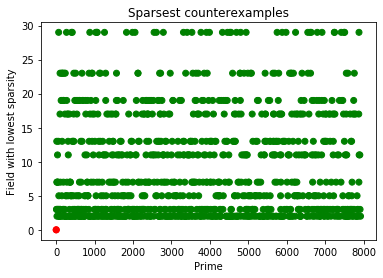

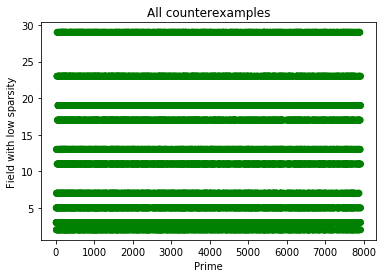

In [3]:
cfexp.plotSparsest(savefig='images/sparsestExmpQagainstP.pdf')
cfexp.plotAll(savefig='images/allExmpQagainstP.pdf')

It seems that all 10 fields used in the experiment give counterexamples, but the small fields generally give sparser factors (note that sparser factors correspond to simpler patterns for the dual functions).

## Always a counterexample?
We should see if each of the 1000 primes tested give us valid counterexamples.

In [4]:
# Make a list of first 1000 primes without Mersenne primes and a list
# of all primes that give counterexamples.
testedPrimes = [Primes().unrank(i) for i in range(1000)]
testedPrimes = [p for p in testedPrimes if not log(p + 1, 2).n() in ZZ]
primeExamples = [exmp[0] for exmp in cfexp.allCounterExmpls]


# Print all prime numbers that do not give counterexamples.
for p in testedPrimes:
    if not p in primeExamples:
        print(f"No counterexample for p = {p}.")

No counterexample for p = 2.
No counterexample for p = 5.


For every prime strictly larger than 5 there are counterexamples!
$\newcommand{\ord}{\mathrm{ord}}$
$\newcommand{\FF}{\mathbb{F}}$
### No counterexample for $p = 2$
For $p = 2$ we have $\Phi_p(X) = 1 + X$ and since $\FF_2^\ast$ is the trivial group, for every prime $q \neq 2$ we have $t = \ord_p(q) = 1$, meaning $\Phi_p(X)$ factors into $\phi(2)/1 = 1$ monic irreducible factor. In other words, $\Phi_p(X)$ is irreducible in $\FF_q[X]$ for all primes $q$ (also for $q = 2$), but $\Phi_p(X)$ has sparsity $2$ which is greater than $t = 1$.

### No counterexample for $p = 3$
Since we skipped Mersenne primes, we skipped $p = 3$, but for that case we have $\mathrm{ord}_p(2) = 2 = p - 1$, which means that $q = 2$ does not give a counterexample, as $\Phi_3$ is irreducible in $\mathbb{F}_2[X]$, but has sparsity $3 > \mathrm{ord}_p(2) = 2$. Since $\phi(p)/2 = 2/2 = 1$, this also shows that if $\mathrm{ord}_p(q) = 2$, then $\Phi_p(X)$ is irreducible in $\FF_q[X]$ and has sparsity $3 > 2 = \mathrm{ord}_p(q)$. Hence, the only possibility for counterexamples emerges for a prime $q$ with $\mathrm{ord}_p(q) = 1$. In that case, $\Phi_3$ factors into $2/1 = 2$ irreducible monic factors each of degree $1$, so
$$
1 + X + X^2 = (X - \alpha)(X - \beta) = X^2 -(\alpha + \beta)X + \alpha\beta.
$$
Then, $\alpha\beta = 1$, implying that $\alpha \neq 0 \neq \beta$, but then both polynomials have sparsity $2 > 1 = \ord_p(q)$. Thus, for $p = 3$ there are no counterexamples.

### No counterexamples for $p = 5$
We have $\FF_5^\ast = \{1, 2, 3, 4\}$ and a simple computation shows that $\ord_5(1) = 1$, $\ord_5(2) = 4$, $\ord_5(3) = 4$, and $\ord_5(4) = 2$. For any prime $q$ with $\ord_5(q) = 4 = p - 1$ there are no counterexamples, as in that case $\Phi_5(X)$ factors into $\phi(5)/4 = 1$ irreducible factor, thus $\Phi_5(X)$ is irreducible and has sparsity $5$ which is larger than the order $4$.

Suppose for a prime $q$ we have $\ord_5(q) = 1$, then $\Phi_5(X)$ factors into $4/1=4$ monic irreducible factors all of degree $1$, thus $1 + X + X^2 + X^3 + X^4 = \Phi_5(X) = (X + \alpha_1)(X + \alpha_2)(X + \alpha_3)(X + \alpha_4)$ with $\alpha_i \in \FF_q$. Suppose this $q$ gives us a counterexample, then one of these factors has sparsity $\leq \ord_p(q) = 1$, which can only be the case if one of the $\alpha_i = 0$. Suppose WLOG that $\alpha_1 = 0$. Then, $\Phi_5(X) = X(X + \alpha_2)(X + \alpha_3)(X + \alpha_4) = X^4 + c_1X^3 + c_2X^2 + c_3X$ with $c_i \in \FF_q$, but then we are missing the constant term $1$ in $\Phi_5(X)$. Hence, each $\alpha_i \neq 0$, but then this gives no counterexample.

The final case is a prime $q$ with $t = \ord_5(q) = 2$. Then, $\Phi_5(X)$ factors into $\phi(5)/t = 4/2 = 2$ monic irreducible factors. Thus, there are $\alpha_1, \alpha_0, \beta_1, \beta_0 \in \FF_q$ such that
$$
\Phi_5(X) = (X^2 + \alpha_1 X + \alpha_0)(X^2 + \beta_1 X + \beta_0).
$$
Suppose this $q$ gives a counterexample, then the sparsity of one factor is at most $2$, thus, without loss of generality, either $\alpha_1 = 0$ or $\alpha_0 = 0$. We show that both cases give a contradiction.
- If $\alpha_0 = 0$, then $\Phi_5(X) = (X^2 + \alpha_1 X)(X^2 + \beta_1 X + \beta_0)$, but then we do not have the constant term $1$. Contradiction!
- Suppose $\alpha_1 = 0$. Then, $$1 + X + X^2 + X^3 + X^4 = \Phi_5(X) = (X^2 + \alpha_0)(X^2 + \beta_1 X + \beta_0) = X^4 + \beta_1X^3 + (\beta_0 + \alpha_0)X^2 + \alpha_0\beta_1X + \alpha_0\beta_0.$$ Since each coefficient of $\Phi_5(X)$ equals 1, this gives us four equations in four variables. From the $X^3$ term, we infer that $\beta_1 = 1$. But then, the $X$ term implies $1 = \alpha_0\beta_1 = \alpha_0$. Then, the constant term implies $1 = \alpha_0\beta_0 = \beta_0$. Finally, the $X^2$ term implies $1 = \beta_0 + \alpha_0 = 1 + 1$, implying $1 = 0$, which is a contradiction.
We conclude that $p = 5$ has no counterexamples.

### The underlying reason that there are no counterexamples for $p = 2, 3, 5$
From the arguments above, we see that they all boil down to the fact that no counterexamples emerge from $\ord_p(q) \in \{1, 2, p-1\}$ and that for $p = 2, 3, 5$ the only possible orders were $\{1, 2, p - 1\}$.

For $\ord_p(q) = 1$ the cyclotomic polynomial factors into $p - 1$ linear monic irreducible factors, and a counterexample only occurs when the sparsity of one of those factors is at most one. However, as the linear coefficient is one (monic polynomials), this means that one constant coefficient must be zero, but then $\Phi_p(X) = X g(X)$ for some polynomial $g \in \FF_q[X]$, but the product $X g(X)$ has no constant term, whereas $\Phi_p(X) = 1 + X + \ldots + X^{p - 1}$. This is a contradiction, so no counterexamples emerge when $\ord_p(q) = 1$.

For $\ord_p(q) = p - 1$ the cyclotomic polynomial $\Phi_p(X)$ factors into $\phi(p)/(p - 1) = 1$ irreducible polynomial, thus $\Phi_p(X)$ is irreducible in $\FF_q[X]$. As $\Phi_p(X)$ has sparstiy $p > p - 1$, this gives no counterexamples.

For $\ord_p(q) = 2$ we know $\Phi_p(X)$ factors into $(p - 1)/2$ monic irreducible polynomials of degree $2$. Suppose this gives a counterexample, then at least one of those factors has sparsity at most $2$. Thus, we have a factor $X^2 + \alpha_0$ (as $X^2 + \alpha_1 X = X(X + \alpha_1)$ is reducible). But then, we have a counterexample for the pattern $\vec i = (0, 2)$ which cannot happen, as proven in the thesis (there are no counterexamples for patterns of the form $\vec i = (0, s, 2s, \ldots, (k - 1)s)$ for any $k, s \in \mathbb{N}$).

For $p > 5$ we know that $\frac{p-1}{2} \notin \{1, 2, p-1\}$, so we are justified to conjecture that there are counterexamples for all primes $p$ (also because strength seems to increase for larger primes, we will see this later on).

## Strength analysis

Next, we analyse the strength of the counterexamples.
We have seen that when the factorisation of the $p$-th cyclotomic polynomial $\Phi_p$ over the field $\mathbb{F}_q$ contains an irreducible factor of sparsity $d$, then if $d \leq t := \mathrm{ord}_p(q)$ a contradiction is derived from the inequality (see thesis)
$$
C_1 n^t \leq C_2 n^{d -1},
$$
which is not true for large $n$, because $d  - 1 < t$. So, a natural first definition of strength, is the difference between the order $t$ and the sparsity $d$, because when this difference is larger, n^{t} grows much faster than n^{d-1}, which contradicts the above inequality for smaller $n$.

Secondly, we know we have counterexamples when the sparsity $d \leq t := \ord_p(q)$, or stated differently, when $d < \ord_p(q) + 1$. This means that we have counterexamples whenever $\frac{\ord_p(q) + 1}{d} > 1$. Hence, we can define strength to be $\frac{\ord_p(q) + 1}{d}$.

Finally, the minimal sparsity is of interest, as these counterexamples correspond to simpler patterns of dual functions. However, as the list of minimal sparsity per prime number is already writen to csvFiles/[fileName]SPARSEST.csv, we will not analyse this further.

We create some functions that will allow us to analyse the strength of the counterexamples.

In [5]:
class StrengthAnalysis:
    """This class implements functions to analyse the strength of a given
    list of counterexamples (sorted on strength)."""
    def __init__(self, cycloFact, strengthList):
        """Initialise StregnthAnalysis object.
        Parameters:
            - cycloFact: CycloFactExperiment object
            - strengthList: a list of tuples (p, q, sparsity, order, strength, p - 1 - order)
                            sorted from highest strength to lowest strength
                            (e.g., output of cycloFact.plotStrength()).
        Attributes:
            - self.cycloFact, self.strengthList (same as parameters above)
            - self.counterFields: dictionary with primes p as keys and list
                                  of tuples (rank, (q, (p - 1)/ord_p(q), sparsity)) that give
                                  counterexamples for this p as value.
            - self.counterExamples: dictionary with primes p as keys and list
                                    of all counterexamples for that p as value.
        """
        assert(len(cycloFact.allCounterExmpls) == len(strengthList))
        self.cycloFact = cycloFact
        self.strengthList = strengthList
        
        # We create a dictionary with as key a prime number p and as
        # value a list of primes q that give counterexamples for that p.
        # We also create a similar dictionary with a list of each
        # counterexample for the key p instead of just the fields q.
        self.counterFields = dict()
        self.counterExamples = dict()
        
        # Initialise dictionaries
        for p in self.cycloFact.primeList:
            # We know there are no counterexamples for p = 2 and p = 5.
            if p == 2 or p == 5:
                continue
            self.counterFields[p] = list()
            self.counterExamples[p] = list()
        
        # Fill in the dictionaries
        for i, (p, q, sparsity, order, strength, diff) in enumerate(self.strengthList):
            self.counterFields[p].append((i, (q, (p - 1)/self.cycloFact.multOrder(p, q), sparsity)))
            self.counterExamples[p].append((i, (p, q, sparsity, order, strength, diff)))
    
    
    def __str__(self):
        """Printing this object results in printing the list of strengths
        with their rankings."""
        string = ""
        string += f"(rank, (p, q, sparsity, order, strength, p - 1 - order))\n"
        string += ',\n'.join([str(elem) for elem in list(enumerate(self.strengthList))])
        return string
    
    
    def __testStrengths(self, question, conditionFunc, firstEncounter=False):
        """This function tests whether a certain condition specified by conditionFunc
        holds for each first encounter of the primes p (thus, it tests whether the condition
        holds for the strongest counterexample of each prime p).
        Parameters:
            - question: a string that is printed at the start of the test.
            - conditionFunc: a function of (p, q, spars, order, strength, diff)
                that returns a boolean. The test 'succeeds' if for each
                counterexample the function returns True.
            - firstEncounter: boolean indicating whether conditionFunc should return
                True for all counterexamples or just for the strongest counterexample
                per prime p.
        Return:
            - list of cases for which the test fails.
        """
        print(f"TEST: {question}")
        print("---------------------------------------------------------------------------")
        # Create a set of the primes that have already been encountered
        # (only used if firstEncounter = True).
        seenPrimes = set()
        conjecture = True
        fails = list()
        
        # Loop over all counterexamples (sorted on strength) and check
        # whether the condition holds.
        for i, (p, q, spars, order, strength, diff) in enumerate(self.strengthList):
            if firstEncounter and p in seenPrimes:
                continue
            seenPrimes.add(p)
            if not conditionFunc(p, q, spars, order, strength, diff):
                conjecture = False
                fails.append((i, (p, q, spars, order, strength, diff)))
                print(f"FAIL: (p, q, spars, ord, strength, p - 1 - ord) = {(p, q, spars, order, strength, diff)}")
                print(f"\nFor the prime {p} (the {i}-th strongest example) the test fails.")
                print(f"{p} has counterexamples for (rank, (q, (p - 1)/ord_p(q), sparsity)) in")
                print(self.counterFields[p])
                print(f"\nAll counterexamples for {p} (sorted on strength) for (p, q, spars, ord, strength, p - 1 - ord) in:")
                print(self.counterExamples[p])
                print('----------------------------------------------------------\n\n')
        res = 'YES!' if conjecture else 'NO...'
        print(f"\nRESULT: {question} {res}")
        return fails
    
    
    def maximalOrderTest(self, firstEncounter=True):
        """This function tests whether counterexamples satisfy ord_p(q) = (p - 1)/2
        (maximal order). The parameter {firstEncounter} specifies whether to check this
        condition for the first encounter of each p or for all counterexamples."""
        word = 'Strongest' if firstEncounter else 'All'
        question = f"{word} counterexamples satisfy ord_p(q) = (p - 1)/2?"
        conditionFunc = lambda p, q, spars, order, strength, diff: order == diff
        return self.__testStrengths(question, conditionFunc, firstEncounter)
    
    
    def smallFieldTest(self):
        """This function tests whether each first encounter of a prime p
        (strongest counterexample for p) corresponds to the smallest
        prime q of all primes q that give a counterexample for p."""
        question = "Strongest counterexample for each p achieved for smallest possible field for p?"
        
        # Sort counterFields on the size of the field F_q.
        sortDict = dict()
        for p in self.cycloFact.primeList:
            # Skip primes without counterexample.
            if p == 2 or p == 5:
                continue
            # self.counterFields[p] is a list of 2-tuples [(rank, (q, (p-1)/ord, spars)), ...]
            sortDict[p] = sorted(self.counterFields[p], key=lambda x:x[1][0])
        conditionFunc = lambda p, q, spars, order, strength, diff, sortDict=sortDict: q == sortDict[p][0][1][0]
        return self.__testStrengths(question, conditionFunc, True)
        
    
    def minimalSparsityTest(self):
        """This function tests whether counterexamples satisfy the relation that
        a lower sparsity corresponds to a stronger counterexample."""
        question = "Strongest counterexample for each p achieved for field with sparsest factor?"

        # Sort counterFields on sparsity
        sortDict = dict()
        for p in self.cycloFact.primeList:
            # Skip primes without counterexample.
            if p == 2 or p == 5:
                continue
            # self.counterFields[p] is a list of 2-tuples [(rank, (q, (p-1)/ord, spars)), ...]
            sortDict[p] = sorted(self.counterFields[p], key=lambda x:x[1][2])
        conditionFunc = lambda p, q, spars, order, strength, diff, sortDict=sortDict: spars == sortDict[p][0][1][2]
        return self.__testStrengths(question, conditionFunc, True)
    
    
    def failToPrimes(self, fails):
        """This function translates the list of failures [(rank, (p, q, spars,..)), ..]
        to a set of prime numbers p for which the test failed."""
        return set([elem[1][0] for elem in fails])
    
    
    def testOccurence(self, question, conditionFunc):
        """This function tests whether a certain condition specified by conditionFunc
        holds for any of the counterexamples for each p.
        Parameters:
            - question: a string that is printed at the start of the test.
            - conditionFunc: a function of (p, q, spars, order, strength, diff)
                that returns a boolean. The test 'succeeds' if for each prime p there is a
                counterexample for which the function returns True.
        """
        print(f"TEST: {question}")
        print("---------------------------------------------------------------------------")
        fails = list()
        
        for p in self.cycloFact.primeList:
            # Skip primes without counterexample.
            if p == 2 or p == 5:
                continue
            # Loop over all counterexamples of p and check whether condition holds.
            for (rank, (p, q, spars, order, strength, diff)) in self.counterExamples[p]:
                if conditionFunc(p, q, spars, order, strength, diff):
                    break
            else:
                print(f"FAIL: prime {p} has no counterexamples that satisfy the condition")
                print(f"Counterexamples for {p} are (rank, (p, q, spars, order, strength, diff)):")
                print(self.counterExamples[p])
                print('----------------------------------------------------------')
                fails.append(p)
        print(f"Found {len(fails)} primes p that fail this test.")
        return fails
    
    
    def compareToKnown(self):
        """This function compares the strength of the counterexamples to the
        counterexamples found by Briet and Labib (ord_p(2) < p - 1).
        The strongest ones for each prime are classified into three groups.
          1. Primes p with ord_p(2) < p - 1 and q = 2 gives strongest counterexample
          2. Primes p with ord_p(2) < p - 1 and q = 2 is not strongest counterexamle
          3. Primes p with ord_p(2) = p - 1.
        The function returns three lists of strongest counterexamples of the prime p,
        one list for each category.
        """
        blStrongest = list()
        blNotStrongest = list()
        noBL = list()

        # Classify each prime to one of the three categories.
        for p in self.cycloFact.primeList:
            # Skip the prime numbers without counterexample.
            if p == 2 or p == 5:
                continue
            if self.cycloFact.multOrder(p, 2) < p - 1:
                # self.counterFields[p] is a list of 2-tuples [(rank, (q, (p-1)/ord, spars)), ...]
                if self.counterFields[p][0][1][0] == 2:
                    blStrongest.append(self.counterExamples[p][0])
                else:
                    blNotStrongest.append(self.counterExamples[p][0])
            else:
                noBL.append(self.counterExamples[p][0])
        summ = len(blStrongest) + len(blNotStrongest) + len(noBL)
        print(f"The {summ} primes analysed can be classified into three groups:")
        print(f"1. For {len(blStrongest)} primes p we have ord_p(2) < p - 1 and q = 2 gives the strongest counterexample")
        print(f"2. For {len(blNotStrongest)} primes p we have ord_p(2) < p - 1 and q = 2 is not the strongest")
        print(f"3. For {len(noBL)} primes p we have ord_p(2) = p - 1.")
        print("----------------------------------------------------------------")
        if len(blStrongest) > 0:
            blStrongest.sort(key=lambda x:x[0])
            print(f"(rank, (p, q, sparsity, order, strength, p - 1 - order)) = {blStrongest[0]} is the strongest one of group 1.")
        if len(blNotStrongest) > 0:
            blNotStrongest.sort(key=lambda x:x[0])
            print(f"(rank, (p, q, sparsity, order, strength, p - 1 - order)) = {blNotStrongest[0]} is the strongest one of group 2.")
        if len(noBL) > 0:
            noBL.sort(key=lambda x:x[0])
            print(f"(rank, (p, q, sparsity, order, strength, p - 1 - order)) = {noBL[0]} is the strongest one of group 3.")
        
        return blStrongest, blNotStrongest, noBL

### Strength $= \mathrm{ord}_p(q) - \mathrm{sparsity}$

Throughout this part, we define strength as $\mathrm{ord}_p(q) - \mathrm{sparsity}$. We get the following plot.

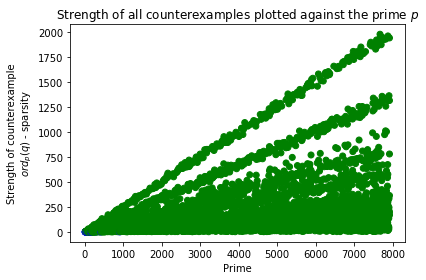

In [6]:
counterExmpStrengths = cfexp.plotStrength(savefig='images/allExmpStrengthDiff.pdf')
cfstrength = StrengthAnalysis(cfexp, counterExmpStrengths)

We see two clear lines of strong examples, where the strength increases linearly when the primes $p$ increase. On the one hand, for larger $p$ the order $\mathrm{ord}_p(q)$ could be larger, but there might be some other reason that these lines occur.

We can also take a look at the list of counterexamples sorted on strength and see if we can find some interesting pattern.

In [7]:
# Change this boolean to print full list.
printFull = False

if printFull:
    print(cfstrength)
else:
    string = str(cfstrength)
    print(string[0:990] + '...')

(rank, (p, q, sparsity, order, strength, p - 1 - order))
(0, (7673, 2, 1855, 3836, 1981, 3836)),
(1, (7879, 2, 1975, 3939, 1964, 3939)),
(2, (7687, 2, 1891, 3843, 1952, 3843)),
(3, (7727, 2, 1911, 3863, 1952, 3863)),
(4, (7919, 2, 2015, 3959, 1944, 3959)),
(5, (7823, 2, 1979, 3911, 1932, 3911)),
(6, (7583, 2, 1867, 3791, 1924, 3791)),
(7, (7759, 2, 1955, 3879, 1924, 3879)),
(8, (7649, 2, 1911, 3824, 1913, 3824)),
(9, (7681, 2, 1933, 3840, 1907, 3840)),
(10, (7433, 2, 1815, 3716, 1901, 3716)),
(11, (7591, 2, 1911, 3795, 1884, 3795)),
(12, (7561, 2, 1897, 3780, 1883, 3780)),
(13, (7417, 2, 1831, 3708, 1877, 3708)),
(14, (7703, 2, 1975, 3851, 1876, 3851)),
(15, (7607, 2, 1939, 3803, 1864, 3803)),
(16, (7457, 2, 1865, 3728, 1863, 3728)),
(17, (7177, 2, 1735, 3588, 1853, 3588)),
(18, (7559, 2, 1947, 3779, 1832, 3779)),
(19, (7127, 2, 1747, 3563, 1816, 3563)),
(20, (6977, 2, 1679, 3488, 1809, 3488)),
(21, (7297, 2, 1841, 3648, 1807, 3648)),
(22, (7039, 2, 1715, 3519, 1804, 3519)),
...


At a first glance, we notice two things.
1. For the strongest counterexamples the 'factor field' $\mathbb{F}_q$ has a small number of elements ($q = 2$ occurs a lot);
2. For the strongest counterexamples we see that $\mathrm{ord}_p(q) = p - 1 - \mathrm{ord}_p(q)$, or stated differently
$$
\mathrm{ord}_p(q) = \frac{p - 1}{2}.
$$ This is the highest possible order, because we only consider cases where $\mathrm{ord}_p(q) < p - 1$ and the order of an element must divide the order of a group (by Lagrange's theorem), which in this case equals $p - 1$.

We start analysing case 1. For each prime $p$ we test whether the strongest counterexample occurs for the smallest prime $q$ for which counterexamples exist.

In [ ]:
smallFieldFails = cfstrength.smallFieldTest()
smallFieldPrimeFails = cfstrength.failToPrimes(smallFieldFails)
print(f'{len(smallFieldPrimeFails)} failed cases')

#### For many of the failed cases, we see that the actual strongest counterexample holds for a $q$ with $\mathrm{ord}_p(q) = (p - 1)/2$.
We try to formalise this.

In [ ]:
count = 0
for (i, (p, q, spars, order, strength, diff)) in smallFieldFails:
    if not order == (p - 1)/2:
        count += 1
        print(f"FAIL: The following counterexample does not satisfy ord_p(q) = (p - 1)/2")
        print(f"For (rank, (p, q, spars, order, strength, diff)) = {(i, (p, q, spars, order, strength, diff))}")
        print(f"-------------------------------")
print(f"{count} fails!")

Most of the 61 of these failed counterexamples still have relatively large order and they still factor over small fields. Furthermore, these counterexamples are fairly weak.

For every p we now plot the smallest q against p to see if we can see a relation.

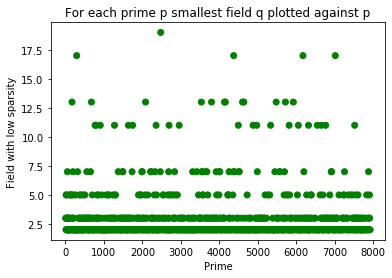

In [10]:
primes, fields, colors = ([], [], [])
# Sort counterFields on the size of the field F_q.
sortDict = dict()
for p in cfexp.primeList:
    # Skip primes without counterexample.
    if p == 2 or p == 5:
        continue
    # cfstrength.counterFields[p] is a list of 2-tuples [(rank, (q, (p-1)/ord, spars)), ...]
    sortDict[p] = sorted(cfstrength.counterFields[p], key=lambda x:x[1][0])
for p in cfexp.primeList:
    if p == 2 or p == 5:
        continue
    primes.append(p)
    # sortDict[p] is a list of 2-tuples [(rank, (q, (p-1)/ord, spars)), ...]
    fields.append(sortDict[p][0][1][0])
    colors.append('green')
cfexp.scatterPlot(primes, fields, colors, 'Prime', 'Field with low sparsity',
                'For each prime p smallest field q plotted against p', savefig='images/smallestQagainstP.pdf')

We see that for a small number of large primes the smallest field $\mathbb{F}_q$ is quite large, but for most of the primes the smallest field is either $q = 2$, $q = 3$ or $q = 5$.

We can now analyse the second step, we repeat it for convenience.
2. For the strongest counterexamples we see that $\mathrm{ord}_p(q) = p - 1 - \mathrm{ord}_p(q)$, or stated differently
$$
\mathrm{ord}_p(q) = \frac{p - 1}{2}.
$$ This is the highest possible order, because we only consider cases where $\mathrm{ord}_p(q) < p - 1$ and the order of an element must divide the order of a group (by Lagrange's theorem), which in this case equals $p - 1$. Let's see if we can find cases where $\mathrm{ord}_p(q) < p - 1$ is not the strongest example for that $p$.

In [ ]:
maxOrdFails = cfstrength.maximalOrderTest()
maxOrdPrimeFails = cfstrength.failToPrimes(maxOrdFails)
print(f'{len(maxOrdPrimeFails)} failed cases')

We see that for the strongest 87 counterexamples it holds that $\mathrm{ord}_p(q) = p - 1 - \mathrm{ord}_p(q)$. It seems that counterexamples are strong when $\mathrm{ord}_p(q) = p - 1 - \mathrm{ord}_p(q)$ _and_ when $q$ is a small prime.

Write $t := \mathrm{ord}_p(q)$, then $t = p - 1 - t$ implies $t = (p - 1)/2$. From theorem 4.1.9 in thesis we know that $\Phi_p$ factors in $\phi(p)/t = (p - 1)/t = 2$ monic irreducible polynomials in $\mathbb{F}_q[X]$, each of degree $t$. Say $\Phi_p(X) = f(X) \cdot g(X)$, with
$$
f(X) = \sum_{i = 0}^t c_i X^i, \quad g(X) = \sum_{i = 0}^t d_i X^i.
$$
Since $\deg(f) = \deg(g) = t$, we know $c_t \neq 0 \neq d_t$.
We also know that
$$
\Phi_p(X) = 1 + X + \cdots + X^{p - 1} = 1 + X + \cdots + X^{2t} = f(X) \cdot g(X).
$$
Thus, each non-zero coefficient of $\Phi_p(X)$ is $1$.
We also know (Cauchy product) that
$$
f(X) \cdot g(X) = \sum_{j = 0}^{2t} \left( \sum_{i = 0}^j c_i d_{j - i} \right) X^j = 1 + X + \cdots + X^{2t}.
$$
From this, we infer that for all $j \in [2t]$ we have
$$
\sum_{i = 0}^j c_i d_{j - i} = 1.
$$
In other words, the convolution of the vectors $\vec{c} = (c_0, c_1, \ldots, c_t)$ and $\vec{d} = (d_0, d_1, \ldots, d_t)$ results in the vector $\vec{1} = (1, 1, \ldots, 1)$ (of length $2t + 1$.
It would be desirable to conclude from this that either $f$ or $g$ does not have maximal sparsity (or maybe even that one of them must have _small_ sparsity). We conjecture that it is possible to infer that one of the two factors cannot have maximal sparsity from the equation above.

If we can prove that whenever $\mathrm{ord}_p(q) = (p - 1)/2$, we have a strong counterexample, then we have found strong counterexamples for all prime numbers $p$, as for every divisor of $\lvert \FF_p^\ast \rvert = p - 1$, there is an element of that order, and (by Dirichlet's theorem on arithmetic progressions) this gives a prime $q$ of that order.

We can compare the fails of our first conjecture to the fails of our second conjecture.

In [ ]:
print(f"{len(smallFieldFails)} primes fail small field test, {len(maxOrdFails)} primes fail the max-ord-test.")
doubleFails = list()
for p in smallFieldPrimeFails:
    if p in maxOrdPrimeFails:
        doubleFails.append(p)
print(f'There are {len(doubleFails)} primes that fail both tests.\n')
for p in doubleFails:
    print(f'Prime {p} gives counterexamples\n(rank, (p, q, spars, ord, strength, p - 1 - ord))')
    print(f'{cfstrength.counterExamples[p]}')
    print('-------------------------\n\n')

We see that the counterexamples that fail both observations, usually have the strongest counterexample for the smallest $q$ that has high order in $\FF_p^\ast$.

For a better overview of the counterexamples that satisfy $\mathrm{ord}_p(q) = (p - 1)/2$, we only plot the strength of those points and compare it to the strength of all counterexamples.

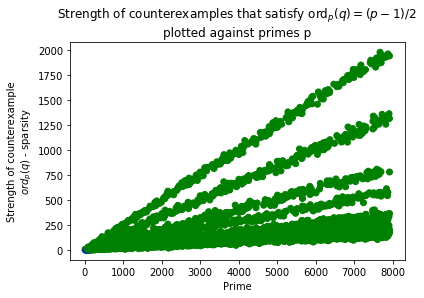

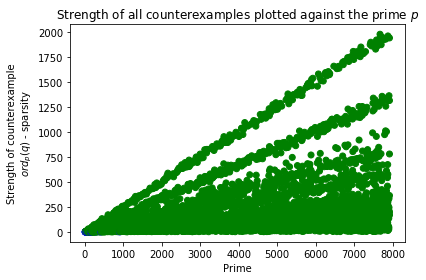

In [13]:
title = 'Strength of counterexamples that satisfy $\\mathrm{ord}_p(q) = (p - 1)/2$\nplotted against primes p'
specOrdExmps = cfexp.plotStrength(title=title, spec=lambda p, q, sparsity, order: order == (p - 1)/2, savefig='images/highOrdStrengthDiff.pdf')
allExmps = cfexp.plotStrength()

We see that the linear lines we noticed earlier correspond to the points that satisfy $\mathrm{ord}_p(q) = (p - 1)/2$. It seems as if these points form different linear lines with different slopes. We compare the number of counterexamples that satisfy this relation to the total number of counterexamples.

In [14]:
print(f"Out of the {len(allExmps)} counterexamples, there are {len(specOrdExmps)} cases that satisfy ord_p(q) = (p - 1)/2.")

Out of the 6130 counterexamples, there are 2847 cases that satisfy ord_p(q) = (p - 1)/2.


Then, we check whether each of our primes p have a $q$ for which there is a counterexample and for which $ord_p(q) = (p - 1)/2$ holds (we note that we only tried the first 10 primes for $q$).

In [ ]:
question = "For each prime p, is there a q that gives a counterexample and satisfied ord_p(q) = (p - 1)/2?"
conditionFunc = lambda p, q, spars, order, strength, diff: order == (p - 1)/2
orderTestFail = cfstrength.testOccurence(question=question, conditionFunc=conditionFunc)

For the cases that fail, we either see that the counterexamples are relatively weak for that prime, or that that prime is large (indicating that maybe trying larger primes for $q$ would give one that satisfies $\mathrm{ord}_p(q) = (p - 1)/2$). For these primes, we test if there are larger primes $q$ with $\mathrm{ord}_p(q) = (p - 1)/2$ that give strong counterexamples.

In [16]:
orderTests = cfexp.searchHighOrder(read=True, fileName='1000primes', primeList=orderTestFail)
weirdPrimes = list()
offset = 0
for i, (p, q, spars, order) in enumerate(orderTests):
    if p != orderTestFail[i + offset]:
        print(f'p = {orderTestFail[i + offset]} is a weird prime')
        offset += 1
    elif spars == order:
        print(f'p = {p} and q = {q} gives sparsity = {spars} = {order} = ord_p(q)')

# If ord_p(q) = (p - 1)/2, do we have strength > 0?
# for i, (p, q, spars, order, strength, diff) in 
question = "For every p, is there a q with ord_p(q) = (p - 1)/2 and sparsity < order?"
conditionFunc = lambda p, q, spars, order, strength, diff: order != (p - 1)/2 or strength > 0
orderTestMajorFail = cfstrength.testOccurence(question=question, conditionFunc=conditionFunc)

print(f'\nFor p = 211 we have counterexamples:\n(rank, (p, q, spars, order, strength, diff))')
print(cfstrength.counterExamples[211])

p = 13 is a weird prime
p = 211 and q = 37 gives sparsity = 105 = 105 = ord_p(q)
TEST: For every p, is there a q with ord_p(q) = (p - 1)/2 and sparsity < order?
---------------------------------------------------------------------------
FAIL: prime 11 has no counterexamples that satisfy the condition
Counterexamples for 11 are (rank, (p, q, spars, order, strength, diff)):
[(6095, (11, 3, 5, 5, 0, 5))]
----------------------------------------------------------
Found 1 primes p that fail this test.

For p = 211 we have counterexamples:
(rank, (p, q, spars, order, strength, diff))
[(5564, (211, 5, 25, 35, 10, 175)), (5896, (211, 13, 31, 35, 4, 175)), (6019, (211, 11, 33, 35, 2, 175)), (6075, (211, 19, 14, 15, 1, 195)), (6076, (211, 23, 9, 10, 1, 200))]


What's wrong with $p = 13$?

In [17]:
cfexp.searchHighOrder(read=False, fileName='primes13and211', primeList=[13, 211])

Primes: [13, 211]
Testing p = 13...
The 0-th iteration of q
PAY ATTENTION: Prime p = 13 and prime q = 17 gives order = 6, but
gives no counterexample when factoring. Sparsity = 7, factors w/ sparsity = [(x^6 + 5*x^5 + 2*x^4 + 4*x^3 + 2*x^2 + 5*x + 1, 7), (x^6 + 13*x^5 + 2*x^4 + 12*x^3 + 2*x^2 + 13*x + 1, 7)]
---------------------------------------------------------
Testing p = 211...
The 0-th iteration of q
Found counterexample! Prime q = 37 has order = 105 in (F_p)^* for p = 211.
---------------------------------------------------------


[(211, 37, 105, 105)]

Finally, we compare the strengths of our counterexamples to those captured by Briët and Labib (they have counterexamples for each prime $p$ that satisfies $\mathrm{ord}_p(2) < p - 1$).
The strongest counterexample for each prime p is classified into one of three groups:
1. Primes p with ord_p(2) < p - 1 and q = 2 gives strongest counterexample
2. Primes p with ord_p(2) < p - 1 and q = 2 is not strongest counterexamle
3. Primes p with ord_p(2) = p - 1.

In [18]:
blStrongest, blNotStrongest, noBL = cfstrength.compareToKnown()

The 994 primes analysed can be classified into three groups:
1. For 447 primes p we have ord_p(2) < p - 1 and q = 2 gives the strongest counterexample
2. For 164 primes p we have ord_p(2) < p - 1 and q = 2 is not the strongest
3. For 383 primes p we have ord_p(2) = p - 1.
----------------------------------------------------------------
(rank, (p, q, sparsity, order, strength, p - 1 - order)) = (0, (7673, 2, 1855, 3836, 1981, 3836)) is the strongest one of group 1.
(rank, (p, q, sparsity, order, strength, p - 1 - order)) = (84, (7873, 3, 2588, 3936, 1348, 3936)) is the strongest one of group 2.
(rank, (p, q, sparsity, order, strength, p - 1 - order)) = (82, (7907, 3, 2588, 3953, 1365, 3953)) is the strongest one of group 3.


For our final test, we test whether the strongest counterexamples correspond to the sparsest found factors. We do this to try to find the relation between the strength of a counterexample and the minimal sparsity for the corresponding prime $p$.

In [ ]:
minSparsFails = cfstrength.minimalSparsityTest()
minSparsPrimeFails = cfstrength.failToPrimes(minSparsFails)

In [20]:
print(f"{len(minSparsPrimeFails)} primes fail the minimal sparsity test")

757 primes fail the minimal sparsity test


Almost every prime fails the minimal sparsity test, so with this strength measure it seems like the minimal sparsity is not so important.

Our main conclusion is still that we conjecture that all primes give counterexamples and that strong counterexamples usually satisfy one of these conditions:
1. For the strongest counterexamples the 'factor field' $\mathbb{F}_q$ has a small number of elements ($q = 2$ occurs a lot);
2. For the strongest counterexamples we see that $\mathrm{ord}_p(q) = p - 1 - \mathrm{ord}_p(q)$, or stated differently
$$
\mathrm{ord}_p(q) = \frac{p - 1}{2}.
$$ This is the highest possible order, because we only consider cases where $\mathrm{ord}_p(q) < p - 1$ and the order of an element must divide the order of a group (by Lagrange's theorem), which in this case equals $p - 1$.
Especially the discussion around the second condition with the convolution of vectors of polynomial coefficients should be researched further.

### Strength $= - \mathrm{sparsity}$

As lower sparsities correspond to simpler dual functions, it is reasonable to define strength as the negative sparsity (such that higher sparsity corresponds to weaker counterexamples).

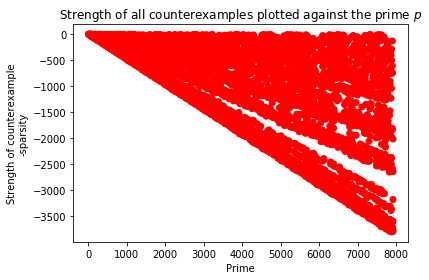

(rank, (p, q, sparsity, order, strength, p - 1 - order))
(0, (13, 3, 3, 3, -3, 9)),
(1, (19, 7, 3, 3, -3, 15)),
(2, (61, 13, 3, 3, -3, 57)),
(3, (67, 29, 3, 3, -3, 63)),
(4, (73, 2, 3, 9, -3, 63)),
(5, (307, 17, 3, 3, -3, 303)),
(6, (1093, 3, 3, 7, -3, 1085)),
(7, (2801, 7, 3, 5, -3, 2795)),
(8, (3221, 11, 3, 5, -3, 3215)),
(9, (13, 5, 4, 4, -4, 8)),
(10, (17, 13, 4, 4, -4, 12)),
(11, (61, 11, 4, 4, -4, 56)),
(12, (71, 5, 4, 5, -4, 65)),
(13, (157, 13, 4, 6, -4, 150)),
(14, (181, 19, 4, 4, -4, 176)),
(15, (313, 5, 4, 8, -4, 304)),
(16, (421, 29, 4, 4, -4, 416)),
(17, (757, 3, 4, 9, -4, 747)),
(18, (3851, 3, 4, 11, -4, 3839)),
(19, (4733, 7, 4, 7, -4, 4725)),
(20, (7321, 11, 4, 8, -4, 7312)),
(21, (11, 3, 5, 5, -5, 5)),
(22, (17, 2, 5, 8, -5, 8)),
(23, (43, 7, 5, 6, -5, 36)),
(24, (89, 2, 5, 11, -5, 77)),
(25, (151, 19, 5, 5, -5, 145)),
(26, (191, 7, 5, 10, -5, 180)),
(27, (257, 2, 5, 16, -5, 240)),
(28, (271, 29, 5, 6, -5, 264)),
...


In [21]:
sparsStrength = cfexp.plotStrength(strengthFunc=(lambda order, spars, p:-spars),
                                   ylabel='-sparsity', savefig='images/allExmpStrengthSparsity.pdf')
sparsStrengthClass = StrengthAnalysis(cfexp, sparsStrength)

# Change this boolean to print full list.
printFull2 = False

if printFull2:
    print(sparsStrengthClass)
else:
    string2 = str(sparsStrengthClass)
    print(string2[0:944] + '...')

In [ ]:
smallFieldFailsSpars = sparsStrengthClass.smallFieldTest()
smallFieldPrimeFailsSpars = sparsStrengthClass.failToPrimes(smallFieldFailsSpars)
print(f'Found {len(smallFieldPrimeFailsSpars)} fails.')

### Strength $= (\ord_p(q) + 1)/\mathrm{sparsity}$

We start again by plotting and printing the strength of counterexamples.

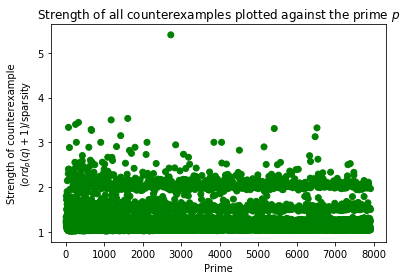

In [23]:
counterExmpStrengths2 = cfexp.plotStrength(strengthFunc=(lambda order, spars, p: (order + 1)/spars),
                                           ylabel='$(ord_p(q) + 1)/$sparsity', savefig='images/strengthQuotientAll.pdf')
cfstrength2 = StrengthAnalysis(cfexp, counterExmpStrengths2)

The plot doesn't give us much information.
Next, we print the list of counterexamples sorted on this strength.

In [24]:
# Change this boolean to print full list.
printFull3 = False

if printFull3:
    print(cfstrength2)
else:
    string3 = str(cfstrength2)
    print(string3[0:939] + '...')

(rank, (p, q, sparsity, order, strength, p - 1 - order))
(0, (2731, 2, 5, 26, 27/5, 2704)),
(1, (1613, 2, 15, 52, 53/15, 1560)),
(2, (1181, 3, 6, 20, 7/2, 1160)),
(3, (331, 2, 9, 30, 31/9, 300)),
(4, (257, 2, 5, 16, 17/5, 240)),
(5, (73, 2, 3, 9, 10/3, 63)),
(6, (6529, 2, 31, 102, 103/31, 6426)),
(7, (5419, 2, 13, 42, 43/13, 5376)),
(8, (661, 3, 7, 22, 23/7, 638)),
(9, (673, 2, 15, 48, 49/15, 624)),
(10, (1429, 2, 27, 84, 85/27, 1344)),
(11, (6481, 3, 8, 24, 25/8, 6456)),
(12, (277, 2, 31, 92, 3, 184)),
(13, (911, 7, 5, 14, 3, 896)),
(14, (2113, 2, 15, 44, 3, 2068)),
(15, (3851, 3, 4, 11, 3, 3839)),
(16, (4051, 2, 17, 50, 3, 4000)),
(17, (2857, 2, 35, 102, 103/35, 2754)),
(18, (1321, 2, 21, 60, 61/21, 1260)),
(19, (5153, 2, 39, 112, 113/39, 5040)),
(20, (601, 2, 9, 25, 26/9, 575)),
(21, (1801, 2, 9, 25, 26/9, 1775)),
(22, (97, 2, 17, 48, 49/17, 48)),
(23, (4513, 2, 17, 47, 48/17, 4465)),
(24, (1657, 2, 33, 92, 31/11, 1564)),
...


In this case, the strongest counterexamples also emerge from small values of $q$, but now the order is generally smaller than $p - 1 - \ord_p(q)$.

Finally, we plot $\ord_p(q) + 1$ against the sparsity.

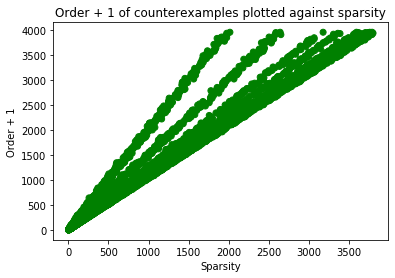

In [25]:
primesP = list()
sparsities = list()
orderPlus1 = list()
colors = list()

for (p, q, spars, order) in cfexp.allCounterExmpls:
    if order + 1 == spars:
        colors.append('blue')
    else:
        colors.append('green')
    primesP.append(p); sparsities.append(spars); orderPlus1.append(order)

# Plot ord + 1 against sparsity.
xlabel = 'Sparsity'
ylabel = 'Order + 1'
title = 'Order + 1 of counterexamples plotted against sparsity'
cfexp.scatterPlot(sparsities, orderPlus1, colors, xlabel, ylabel, title, savefig='images/ordAgainstSpars.pdf')

Here we see a couple of 'linear' lines.

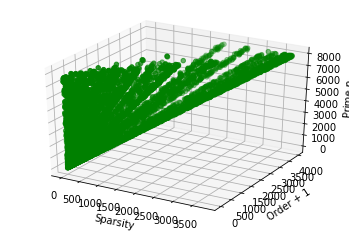

In [26]:
# Plot ord + 1 agaianst sparsity and plot primes p. (Source: https://matplotlib.org/3.2.1/gallery/mplot3d/scatter3d.html)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sparsities, orderPlus1, primesP, marker='o', color=colors)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel('Prime $p$')

plt.show()
fig.savefig('images/sparsOrdPrimes3D.pdf', bbox_inches='tight')

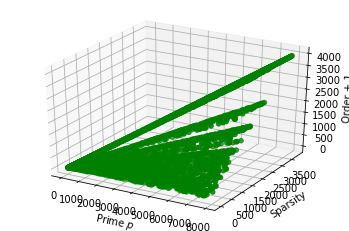

In [27]:
# Plot ord + 1 agaianst sparsity and plot primes p. (Source: https://matplotlib.org/3.2.1/gallery/mplot3d/scatter3d.html)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(primesP, sparsities, orderPlus1, marker='o', color=colors)

ax.set_ylabel(xlabel)
ax.set_zlabel(ylabel)
ax.set_xlabel('Prime $p$')

plt.show()
fig.savefig('images/primesSparsOrd3D.pdf', bbox_inches='tight')

# Further research
A couple of interesting questions remain unaswered and didn't fit into the time span of the thesis:
- _For strength = ord - sparsity:_
    - why does it sometimes happen that $\ord_p(q) = (p - 1)/3$ gives a stronger counterexample, while $\ord_p(q) = (p - 1)/2$ also holds for some other field $\FF_q$?
        - Maybe $\ord_p(q) = (p - 1)/2$ is only strongest, when $q$ is small? In other words, maybe the strongest counterexamples emerge for the smallest $q$ that has `high' order in $\FF_p^\ast$. This can be experimented by analysing the ratio $\ord_p(q)/q$.
    - Why do the primes $p = 13, 211$ have weird behaviour when factoring over fields $\FF_q$ with $\ord_p(q) = (p - 1)/2$?
        - why does $p = 13$ and $q = 17$ (such that $\ord_p(q) = (p - 1)/2 = 6$) give no counterexamples?
            - does $p = 13$ have other counterexamples over $\FF_q$ with $\ord_p(q) = (p - 1)/2 = 6$?
            - how does the strength of the counterexamples for $p = 13$ behave?
        - For $p = 211$ and $q = 37$ (such that $\ord_p(q) = (p - 1)/2 = 105$), the sparsity equals the order. Why does this weak counterexample happen? Is there a larger primes $q$ with the same order, but with a stronger counterexample?
        - Is such behaviour unique to $p = 13$ and $p = 211$ (these are the only two primes in the first 1000 primes with this behaviour), or are there larger primes $p$ with the same weird behaviour?
    - For the primes that had a stronger counterexample for a larger field $\FF_q$ (larger than the smallest possible $q$), was the next smallest $q$ the strongest counterexample? Is there another reason?
- _For strength = (ord + 1)/sparsity:_
    - why do we see the linear lines?